# Kaggle Competition: Predicting Housing Prices

In this project, we will participate in a [Kaggle](https://www.kaggle.com/) competition: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

---

> <strong>Sotiris Baratsas</strong> <br />
> MSc in Business Analytics <br />
> https://www.baratsas.com/contact <br />



We will start this project with some exploration of the data, as we seldom start applying machine learning methods without first gaining some understanding of the nature of the problem and its features.


In [0]:
import pandas as pd
import numpy as np

# Importing plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
flatui = [ "#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style='white', context='notebook', palette=flatui)

# Importing statistics libraries
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr, spearmanr

# Importing ML libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Muting warning messages
import warnings
warnings.filterwarnings('ignore')


### Data Import

* We import both the "train" and "test" dataset.
* As we can see, the Training dataset has 1460 observations and 81 columns, while the Test dataset has 1459 observations and 80 columns (since it's missing the target variable).

In [0]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
print("Train Dataset: " + str(train.shape))
print("Test Dataset: " + str(test.shape))
train.head()

Train Dataset: (1460, 81)
Test Dataset: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
# Saving the ID column for the submission file
test_ID = test["Id"]

# Dropping the column "Id", since it's a non-explanatory variable.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("Train Dataset: " + str(train.shape))
print("Test Dataset: " + str(test.shape))

Train Dataset: (1460, 80)
Test Dataset: (1459, 79)


In [0]:
# Checking the remaining columns
print(train.columns.size)
train.columns

80


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Exploratory data analysis

In [0]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

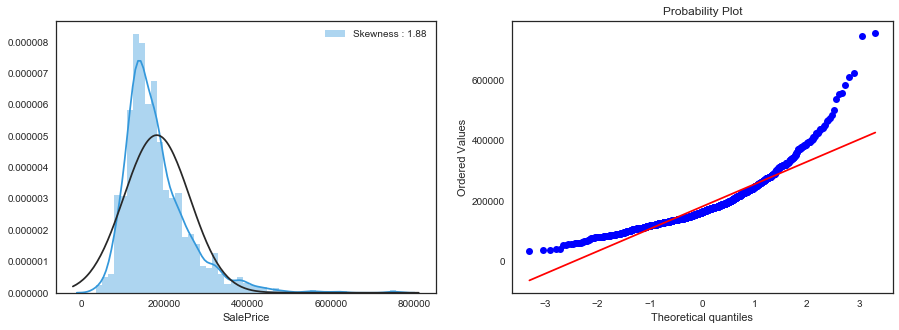

In [0]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="top-right")

plt.subplot(1, 2, 2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

* As we can see from the graphs, our response (`SalePrice`) has a large positive skewness. This might be a problem for linear-based model. We will try to transform the variable, using a log transformation and see if this corrects the normality of the variable.

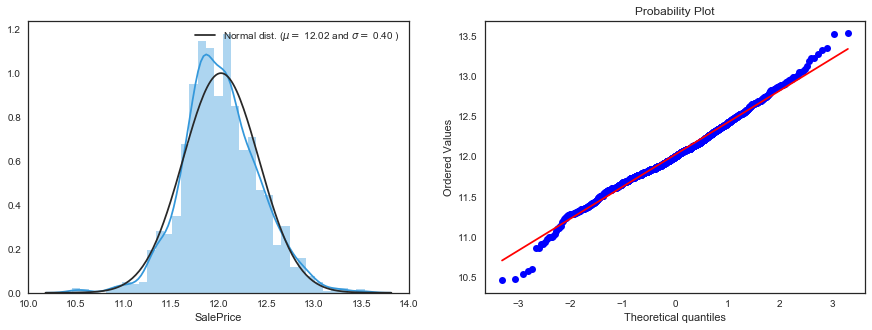

In [0]:
# Applying a log transformation in the column "SalePrice"
train["SalePrice"] = np.log(train["SalePrice"])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Plotting the Distribution and the QQPlot
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.distplot(train['SalePrice'], fit=norm)
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='top-right')

plt.subplot(1, 2, 2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

* As we can see, the log transformation has largely improved the normality of our distribution.

##### Correlation

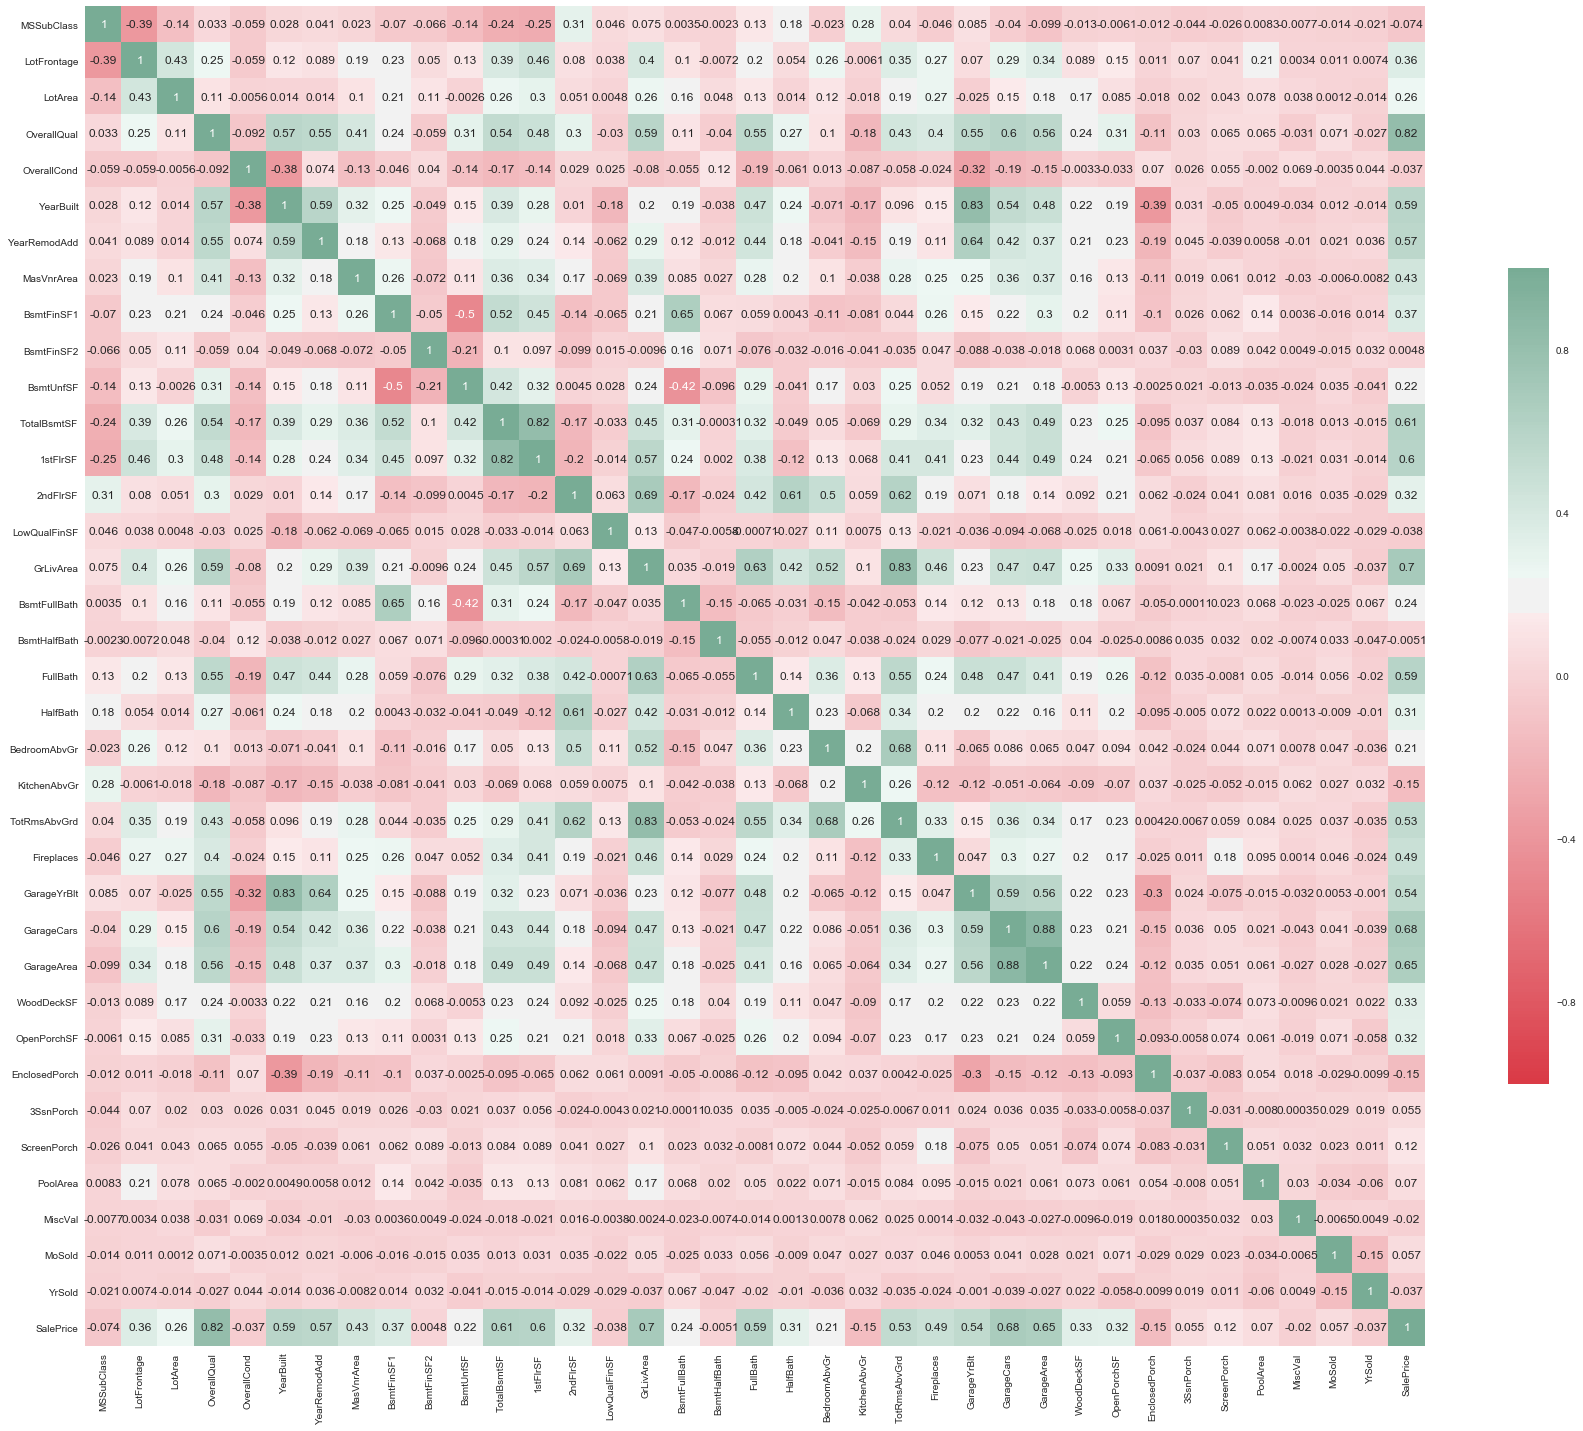

In [0]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(10, 150, n=9, as_cmap=True, center="light")
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1.0, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

The 10 variables with the strongest correlation with `SalePrice` are:
* OverallQual
* GrLivArea
* GarageCars
* GarageArea (the last 2 are strongly correlated --> !Beware for multicollinearity problems)
* TotalBsmtSF
* 1stFlrSF
* FullBath
* TotalRmsAbvGr
* YearBuilt
* YearRemodAdd

In a later step, we will use those in various transformations, in order to produce a better model.

# Data Cleaning

##### Dealing with Leverage Points

* Our first task is to check if we have any influential (leverage) points tat may disrupt the fit of our predictive model.

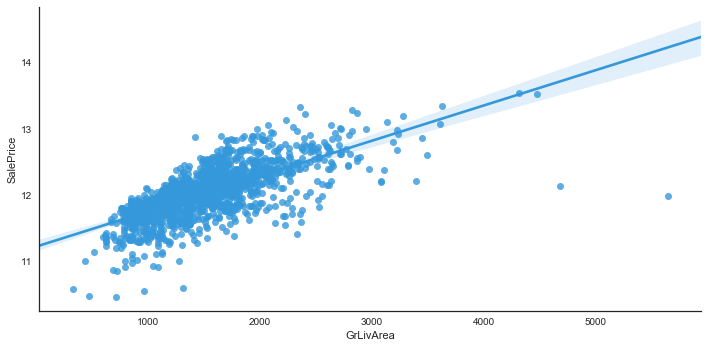

In [0]:
# Checking for outliers using the 'GrLivArea' variable
sns.lmplot('GrLivArea', 'SalePrice', train, size=5, aspect=2)

We can identify 2 observations with a very high value in `GrLivArea`, but a price below 200k, which is odd.
We will remove this observations, since they seem like rare exceptions.

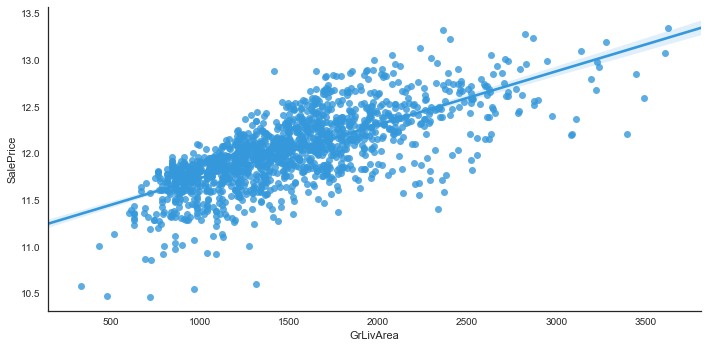

In [0]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

sns.lmplot('GrLivArea', 'SalePrice', train, size=5, aspect=2)                                                       

* We notice that the 2 leverage points have been removed from the dataset.
* Plotting some other important variables, we do not seem a lot of extreme values. Instead of deleting other outliers we will try to deal with them through a good model formulation.

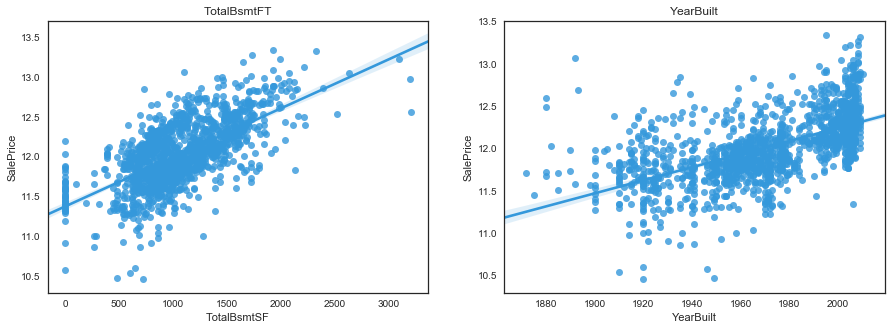

In [0]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'], fit_reg=True).set_title("TotalBsmtFT")

plt.subplot(1, 2, 2)
g = sns.regplot(x=train['YearBuilt'], y=train['SalePrice'], fit_reg=True).set_title("YearBuilt")


### Dealing with missing values

* The second part of our data cleaning process, is dealing with missing values.
* First, we get an idea about the variables that have missing values.
* Then, with a little help from the `data_description.txt` file that containts description for each variable, we will choose how to deal with each one individually, in order to replace the missing values with something reasonable.
* <strong>The most important part</strong> at this stage, is to make sure that whatever way we choose to deal with missing values in the Training dataset, we keep it consistent in the Test dataset. For that reason, we will concatenate the 2 datasets, perform the changes in the joint dataset and then split it again before we start the Model Formulation.

##### Concatenating the test + train datasets

In [0]:
# Saving each datasets length, in order to split them again later.
train_length = len(train)
test_length = len(test)

# Saving the 'SalePrice' column that is only included in the Train Dataset. We will remove it and append it again later.
y_train = train.SalePrice.values

# Concatenating the datasets
joint = pd.concat((train, test)).reset_index(drop=True)

# Dropping the 'SalePrice' column, because it has values only for the train dataset
joint.drop(['SalePrice'], axis=1, inplace=True)

print(joint.shape)
joint.head()


(2915, 79)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


##### Getting an idea about Missing Values

* First, we need to check which variables have missing values and how many each

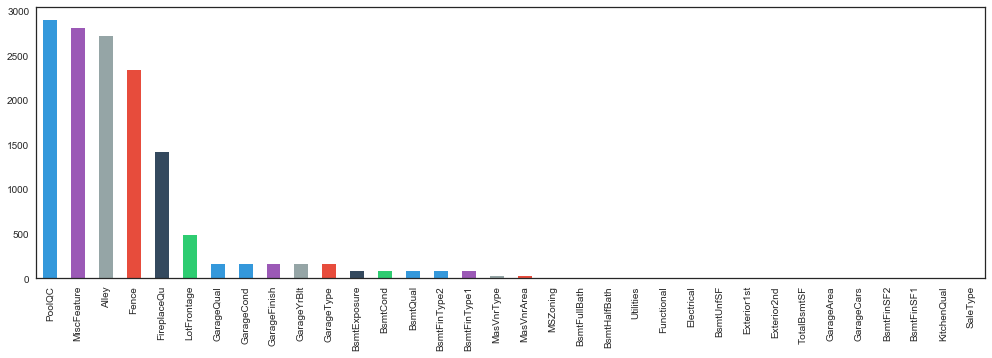

In [0]:
# Sum all the missing values
NAs = joint.isnull().sum()

# Filtering out the columns that don't have missing values
NAs = NAs.drop(NAs[NAs == 0].index).sort_values(ascending=False)

# Plotting the count bars to get an idea of the missing values each column has
NAs.plot(kind='bar', figsize =(17, 5))

* We can observe that the variables `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have a huge amount of missing values.
* Also, there are quite a few columns that have only 1 or 2 missing values (the ones that have a non-visible bar).
* In total, there's missing values in 34 columns of our dataframe.

##### Variables to fill with "None"

* There are certain variables (mainly categorical variables that concern features of the house), where the existence of a missing value or an NA, indicates that the house does not have that particular feature. We will fill these missing values with "None".

In [0]:
col = ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", 
       "GarageQual", "GarageCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
       "MasVnrType", "MSSubClass")

for i in col:
    joint[i] = joint[i].fillna("None")

##### Variables to fill with 0

* For numeric variables, the meaning of a null value, is that this value is equal to zero (0). That's why we will replace missing values with 0.

In [0]:
col = ("GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
       "TotalBsmtSF", "MasVnrArea", "BsmtFullBath", "BsmtHalfBath")

for i in col:
    joint[i] = joint[i].fillna(0)

##### Variables with very low missing values (strings)

* For variables that have a very low number of missing values (mostly 1 value missing), we will replace them with the most common value (string) in the whole column , since it will keep the proportions of the values fairly unchanged.

In [0]:
col = ("MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType", "Functional")

for i in col:
    joint[i] = joint[i].fillna(joint[i].mode()[0])

##### Other Variables

* For the `GarageYrBlt` variable, a sensible assumption is that it was built the same year as the house, or that even if the Garage is younger than the house, it would have a large impact on the price of the house.
* For the `LotFrontage` variable, a sensible assumption is that the Lot Frontage of a house is similar to the other houses in the same neighborhood. That's why we will replace the missing values with the median value of the LotFrontage for the specific neighborhood. We don't use the Average, because it might be influenced by some extreme values. Here, the median is a better option to get realistic values.
* The `Utilities` variable, seems to be quite unhelpful, since all the houses have full utilities (AllPub), instead of 2 houses in the test dataset that have NoSeWa (=Electricity and Gas Only) and 2 missing values. There is no way to make this feature helpful for our predictive model, so we will drop it entirely.


In [0]:
# Fixing missing values for GarageYrBlt
joint["GarageYrBlt"] = joint["GarageYrBlt"].fillna(joint["YearBuilt"])

# Fixing missing values for LotFrontage
joint["LotFrontage"] = joint.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Dropping the Utilities variable
joint = joint.drop(['Utilities'], axis=1)

##### Checking to see if there are any missing values

* After our treatment of missing values has been completed, we do a final check to see if we have any missing values left.
* Since, we don't have any missing values, we are good to go (to the next step).

In [0]:
print("# of missing values = " + str(joint.isnull().sum().sum()))

# of missing values = 0


##### Adding some additional features

In [0]:
# Total Sq Feet of the house
joint['TotalSF'] = joint['TotalBsmtSF'] + joint['1stFlrSF'] + joint['2ndFlrSF']

# Freshness: How old was the house when it was sold
joint['Freshness'] = joint['YrSold'] - joint['YearBuilt']

### Dealing with wrong data types

* Some of our variables have the wrong data type.
* Specifically, the variables `MSSubClass`, `YrSold`, `MoSold` and `OverallCond` are treated as numbers from the dataset, while in reality they are structured in a categorical way (with different levels). That's why we will convert them to strings.

In [0]:
joint.dtypes

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
                  ...   
LotShape          object
LowQualFinSF       int64
MSSubClass         int64
MSZoning          object
MasVnrArea       float64
MasVnrType        object
MiscFeature       object
MiscVal            int64
MoSold             int64


In [0]:
# Converting to categorical features
col = ("YrSold", "MoSold", "OverallCond")
for i in col:
    joint[i] = joint[i].astype(str)
    
joint['MSSubClass'] = joint['MSSubClass'].apply(str)

##### Label Encoding categorical variables

In [0]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for i in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(joint[i].values)) 
    joint[i] = lbl.transform(list(joint[i].values))

# shape        
print('Shape joint: {}'.format(joint.shape))


Shape joint: (2915, 80)


### Data Transformation

*italicized text*##### Quadratic - Cubic - Square Root Transformations

* Adding those did not considerably improve the model, so I chose to skip them.

In [0]:
# Quadratic Transformation for the top numeric variables
joint["OverallQual^2"] = joint["OverallQual"] ** 2
joint["GrLivArea^2"] = joint["GrLivArea"] ** 2
joint["GarageCars^2"] = joint["GarageCars"] ** 2
joint["GarageArea^2"] = joint["GarageArea"] ** 2
joint["TotalBsmtSF^2"] = joint["TotalBsmtSF"] ** 2
joint["1stFlrSF^2"] = joint["1stFlrSF"] ** 2
joint["FullBath^2"] = joint["FullBath"] ** 2
joint["TotRmsAbvGrd^2"] = joint["TotRmsAbvGrd"] ** 2

# Cubic Transformation for the top numeric variables
joint["OverallQual^3"] = joint["OverallQual"] ** 3
joint["GrLivArea^3"] = joint["GrLivArea"] ** 3
joint["GarageCars^3"] = joint["GarageCars"] ** 3
joint["GarageArea^3"] = joint["GarageArea"] ** 3
joint["TotalBsmtSF^3"] = joint["TotalBsmtSF"] ** 3
joint["1stFlrSF^3"] = joint["1stFlrSF"] ** 3
joint["FullBath^3"] = joint["FullBath"] ** 3
joint["TotRmsAbvGrd^3"] = joint["TotRmsAbvGrd"] ** 3


# Square Root Transformation for the top numeric variables
joint["OverallQual-Sq"] = np.sqrt(joint["OverallQual"])
joint["GrLivArea-Sq"] = np.sqrt(joint["GrLivArea"])
joint["GarageCars-Sq"] = np.sqrt(joint["GarageCars"])
joint["GarageArea-Sq"] = np.sqrt(joint["GarageArea"])
joint["TotalBsmtSF-Sq"] = np.sqrt(joint["TotalBsmtSF"])
joint["1stFlrSF-Sq"] = np.sqrt(joint["1stFlrSF"])
joint["FullBath-Sq"] = np.sqrt(joint["FullBath"])
joint["TotRmsAbvGrd-Sq"] = np.sqrt(joint["TotRmsAbvGrd"])


##### Treating skewed features

* Our dataset containts some extremely skewed features. These may largely affect the model's predictive ability.
* One solution would be to transform them, using the Box-Cox Transformation.
* To do that, we will separate the numeric columns and use the `boxcox1p()` function on the variables that have an extremely large skewness (>0.75).

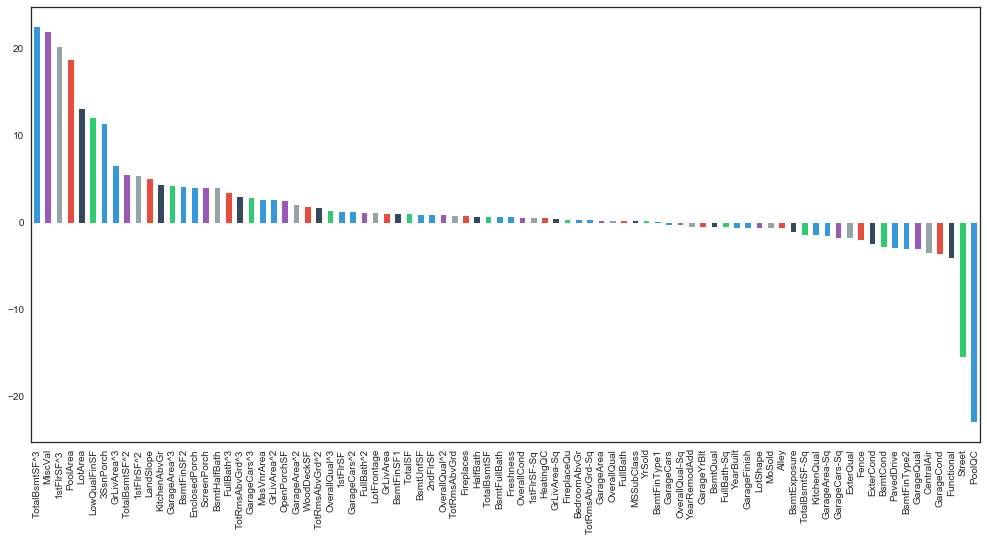

In [0]:
# Getting the indices of numeric columns
numcolumns = joint.dtypes[joint.dtypes != "object"].index

# Check how skewed they are
skewed = joint[numcolumns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(17, 8))
skewed.plot(kind='bar');

In [0]:
# We will transform only the variables that have an extremely large skewness (>0.75)
skewness = skewed[abs(skewed) > 0.75]

skewed = skewness.index
lam = 0.15
for i in skewed:
    joint[i] = boxcox1p(joint[i], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

54 skewed numerical features have been Box-Cox transformed


##### Creating dummy variables for different categorical lavels

Since some of our categorical data may be misinterpreted by the model as hierarchical (e.g. 20 < 40 < 60), we will use the `get_dummies` function of pandas, in order to create dummy categorical colums with 1s and 0s.

In [0]:
joint = pd.get_dummies(joint)
print(joint.shape)
joint.head()

(2915, 245)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.692623,11.686189,0.0,1,3,1.820334,1.540963,11.170327,0.0,2,...,0,0,0,0,0,0,0,0,0,1
1,12.792276,0.000000,0.0,1,3,1.820334,0.730463,12.062832,0.0,0,...,0,0,0,0,0,0,0,0,0,1
2,11.892039,11.724598,0.0,1,3,1.820334,1.194318,10.200343,0.0,2,...,0,0,0,0,0,0,0,0,0,1
3,12.013683,11.354094,0.0,1,3,0.730463,1.540963,8.274266,0.0,0,...,0,0,0,0,0,0,0,0,0,1
4,12.510588,12.271365,0.0,1,4,1.820334,0.000000,10.971129,0.0,2,...,0,0,0,0,0,0,0,0,0,1


-----------------------

##### Re-creating the Train & Test Datasets 

* Now that our data preparation is complete, we will re-create the original datasets, using the length variables we  saved in the beginning.

In [0]:
train = joint[:train_length]
test = joint[train_length:]

In [0]:
print("Train Dataset: " + str(train.shape))
print("Test Dataset: " + str(test.shape))

Train Dataset: (1456, 245)
Test Dataset: (1459, 245)


# Model Formulation

##### Cross-validation parameters

* First, we define a cross-validation function to get the RMSE of each model, using 10-fold cross-validation.

In [0]:
n_folds = 10

def rmsle_cv(model):
    kfolds = KFold(n_folds, shuffle=True, random_state=13).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kfolds))
    return(rmse)

### LASSO model

* Our first try is to use a penalized LASSO model, which will select the best variables to use and produce the coefficients we'll use for our predictions.

In [0]:
lasso = Lasso(alpha =0.0005, random_state=1)
lasso.fit(train.values, y_train)
lasso_pred = np.exp(lasso.predict(test.values))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1086 (0.0148)



* To avoid being influenced by extreme values, we may use the RobustScaler() function, to make the model more robust to outliers.

In [0]:
lasso1 = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso1.fit(train.values, y_train)
lasso1_pred = np.exp(lasso1.predict(test.values))
score = rmsle_cv(lasso1)
print("Lasso (Robust Scaled) score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso (Robust Scaled) score: 0.1081 (0.0149)



* We see that the Lasso Model, gives quite good results. 
* However, we need to confirm that, by submitting the results to Kaggle, since it might be a case of overfitting.

### Elastic Net Model

In [0]:
elnet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42)
elnet.fit(train.values, y_train)
elnet_pred = np.exp(elnet.predict(test.values))
score = rmsle_cv(elnet)
print("Elastic Net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Elastic Net score: 0.1084 (0.0149)



### Decision Tree model

* To decide a good number of levels, we will try different `max_depth` values and run k-fold validation to get the scores.

In [0]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
from sklearn.tree import DecisionTreeRegressor

all_depths = []
all_mean_scores = []
for max_depth in range(1, 11):
    all_depths.append(max_depth)
    simple_tree = DecisionTreeRegressor(max_depth=max_depth)
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = cross_val_score(simple_tree, train.values, y_train, cv=cv)
    mean_score = np.mean(scores)
    all_mean_scores.append(np.mean(scores))
    print("max_depth = ", max_depth, scores, mean_score, sem(scores))

max_depth =  1 [0.41282812 0.44941226 0.47426398 0.44777617 0.51008933] 0.4588739721335509 0.01611330349612056
max_depth =  2 [0.64432904 0.69164377 0.69440032 0.65762311 0.67350517] 0.6723002813266198 0.009648430054285586
max_depth =  3 [0.70579262 0.74433284 0.7602909  0.73185943 0.74253998] 0.7369631536509068 0.00902010782207295
max_depth =  4 [0.76202884 0.79050404 0.78722637 0.72115843 0.77603228] 0.7673899913104691 0.012586757174882399
max_depth =  5 [0.79744785 0.79201426 0.79819598 0.73198015 0.76637732] 0.7772031124627896 0.012712659409958957
max_depth =  6 [0.77451245 0.78934488 0.76398449 0.72919699 0.74606638] 0.7606210377522442 0.0105561648127273
max_depth =  7 [0.74466457 0.76539332 0.74499201 0.72507594 0.72568522] 0.7411622119872008 0.007457833532366795
max_depth =  8 [0.75526313 0.76802696 0.74838126 0.70138318 0.73011765] 0.7406344375067825 0.01156638630352316
max_depth =  9 [0.74677968 0.77875177 0.75454545 0.71682642 0.72178477] 0.7437376178843131 0.0113097192346381

* We can see that the best score is when we have 5 levels.

Text(0,0.5,'mean score')

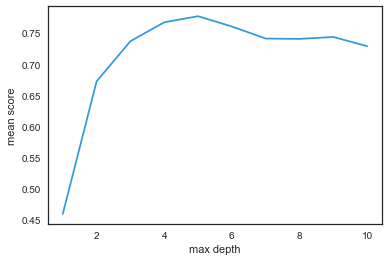

In [0]:
plt.plot(all_depths, all_mean_scores, label='True y')
plt.xlabel('max depth')
plt.ylabel('mean score')

In [0]:
# Designing the Decision Tree Regressor with max_depth = 5
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(train.values, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
# Extracting the predictions for the test dataset
dtree_pred = np.exp(tree.predict(test.values))

In [0]:
# Checking the RMSE Score
score = rmsle_cv(tree)
print("Decision Tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Decision Tree score: 0.1848 (0.0172)



### Random-forest model

* Unfortunately, the Decision Tree model does not produce a very good result.
* We can try running a Random Forest model, which is supposed to produce better results than a simple decision tree, thanks to bagging or bootstrap.

In [0]:
from sklearn.ensemble import RandomForestRegressor

# Building the Random Forest Regressor
rfr = RandomForestRegressor(max_depth=None, random_state=0, min_samples_split=2, 
                              n_estimators=100)
rfr.fit(train.values, y_train)
rfr_pred = np.exp(rfr.predict(test.values))
score = rmsle_cv(rfr)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 0.1366 (0.0143)



* The Random Forest model indeed gives better results, but still, there's room for improvement.

### Ada Boosting

* We now move to Boosting methods.
* AdaBoost with `n_estimators=500` provides similar results.

In [0]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(tree, n_estimators=500)
ada.fit(train.values, y_train)
ada_pred = np.exp(ada.predict(test.values))
score = rmsle_cv(ada)
print("Ada Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ada Boosting score: 0.1389 (0.0112)



### XGBoost

* Running XGBoost, provides better results.
* We may try to calculate the optimal parameters for the algorithm, using Hyper-parameter tuning.

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.5, 
                          learning_rate = 0.15,
                          max_depth = 4, 
                          reg_lambda = 0.5, 
                          n_estimators = 100)
xg_reg.fit(train.values, y_train)
xg_reg_pred = np.exp(xg_reg.predict(test.values))
score = rmsle_cv(xg_reg)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBoost score: 0.1176 (0.0139)



In [0]:
from sklearn.model_selection import GridSearchCV

# We create a parameter grid
params = {
    'objective': ['reg:linear'],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5], 
    'reg_lambda': [0.5, 0,75, 1],
    'reg_alpha': [0.2, 0.4, 0.6],
    'subsample': [0.25, 0.5]
}



xgb_model = xgb.XGBRegressor()

# We use Grid Search in order to run 5-fold cross-validation and select the optimal values for the parameters
clf = GridSearchCV(xgb_model, 
                   params, 
                   n_jobs=-1, 
                   cv=5, 
                   scoring='neg_mean_absolute_error',
                   verbose=2,
                   iid=False,
                   refit=True)

clf.fit(train.values, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TypeError: '<=' not supported between instances of 'NoneType' and 'int'

In [0]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.15, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.2,
       reg_lambda=0, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [0]:
xg_reg = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xg_reg.fit(train.values, y_train)
xg_reg_pred = np.exp(xg_reg.predict(test.values))
score = rmsle_cv(xg_reg)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBoost score: 0.1142 (0.0139)



### LightGBM

* Another gradient boosting option is Microsoft's LightGBM method.
* At first, it does not seem to produce better results, but the results improve considerably if we perform hyper-parameter tuning and select the optimal values for the parameters.

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05)
model_lgb.fit(train.values, y_train)
model_lgb_pred = np.exp(model_lgb.predict(test.values))
score = rmsle_cv(model_lgb)
print("LightGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LightGBM score: 0.1302 (0.0137)



In [0]:
from sklearn.model_selection import GridSearchCV

params = {
    'objective': ['regression'],
    'num_leaves' : [4, 5, 6], 
    'n_estimators' : [500, 550, 600, 650, 700, 750, 800],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5], 
    'reg_lambda': [0.5, 0,75, 1, 2]
}

model_lgb = lgb.LGBMRegressor()

clf = GridSearchCV(model_lgb, 
                   params, 
                   n_jobs=-1, 
                   cv=5, 
                   scoring='neg_mean_absolute_error',
                   verbose=2,
                   iid=False,
                   refit=True)

clf.fit(train.values, y_train)

Fitting 5 folds for each of 945 candidates, totalling 4725 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 4725 out of 4725 | elapsed: 33.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'objective': ['regression'], 'num_leaves': [4, 5, 6], 'n_estimators': [500, 550, 600, 650, 700, 750, 800], 'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [3, 4, 5], 'reg_lambda': [0.5, 0, 75, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [0]:
clf.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=750, n_jobs=-1, num_leaves=4, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.5, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(train.values, y_train)
model_lgb_pred = np.exp(model_lgb.predict(test.values))
score = rmsle_cv(model_lgb)
print("LightGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LightGBM score: 0.1130 (0.0161)



### Neural Networks with Keras

* Trying to see if Neural Networks (with Keras) can produce a better result.
* We create a sequential model with 3 layers.
* We use the `adam` optimizer with `mse` as loss measure and as a metric, too.

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu',
                                 input_shape=(train.shape[1],)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

skf = KFold(n_splits=5)

Using 5-fold cross-validation, we run the odel for 100 epochs, and record the history for the MSE metric.

In [0]:
num_epochs = 100
all_scores = []
all_mse_histories = []

for i, (train_indx, test_indx) in enumerate(skf.split(train.values, y_train)):
    print(f'Processing Fold: {i+1}')
    partial_train_data = train.values[train_indx]
    partial_train_targets = y_train[train_indx]
    partial_val_data = train.values[test_indx]
    partial_val_targets = y_train[test_indx]
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(partial_val_data, partial_val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mse_history = history.history['mean_squared_error']
    all_mse_histories.append(mse_history)
    
print('Done')

Processing Fold: 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Processing Fold: 2
Processing Fold: 3
Processing Fold: 4
Processing Fold: 5
Done


Visualizing the history of the MSE metric, we see that at beyond 30-40 epochs, the decrease is not considerable anymore

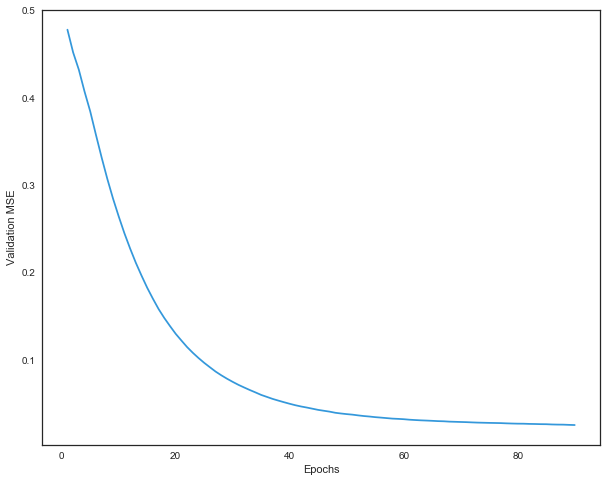

In [0]:
average_mse_history = [
    np.mean([x[i] for x in all_mse_histories]) 
    for i in range(num_epochs)
]

smooth_mse_history = pd.DataFrame(average_mse_history[10:]).ewm(alpha=0.1, adjust=False).mean()
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(smooth_mse_history) + 1), smooth_mse_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.show()

In [0]:
num_epochs = 40
keras = model.fit(train.values, y_train, epochs=num_epochs, batch_size=1, verbose=0)
keras_pred = np.exp(model.predict(test.values))
test_mse_score = model.evaluate(train.values, y_train)
print(np.sqrt(test_mse_score))


1456/1456 [==============================] - 0s 36us/sample - loss: 0.0865 - mean_squared_error: 0.0865
[0.29418113 0.29418113]


### Stacking

Our final approach, will be using a Stacked Regression Model. To implement it:
* We will split the training dataset in a 70% training and a 30% validation set
* We will use the training set to fit the XGBoost, LightGBM, ElasticNet and AdaBoost models and predict the values for the newly-created validation datasetset, as well as the actual test dataset
* After that, knowing the actual values of the target variable for the validation dataset, we will train Lasso as a meta-model, in order to create predictions for the actual test dataset, using the predictions from the other models.

First we perform a train_test_split, in order to split the Training dataset in 70% training set and a 30% validation set for the stacking algorithm.
* x_trn = predictor features for estimation dataset
* x_val = predictor variable for estimation dataset
* y_trn = target variable for the estimation dataset
* y_val = target variable for the validation dataset

In [0]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split 

In [0]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
x_trn, x_val, y_trn, y_val = model_selection.train_test_split(train.values, y_train, test_size=0.3, random_state=42)
print('x_trn: ', x_trn.shape, '\nx_val: ', x_val.shape, '\ny_trn: ', y_trn.shape, '\ny_val: ', y_val.shape)

x_trn:  (1019, 221) 
x_val:  (437, 221) 
y_trn:  (1019,) 
y_val:  (437,)


In [0]:
# Creating 2 dataframes, in which we will stack the predictions
stacked_validation = pd.DataFrame()
stacked_test = pd.DataFrame()

# Fitting XGBoost, LightGBM, ElasticNet and AdaBoost using the new test + validation dataset
xg_reg.fit(x_trn, y_trn)
model_lgb.fit(x_trn, y_trn)
elnet.fit(x_trn, y_trn)
ada.fit(x_trn, y_trn)

# Making predictions for the validation dataset
predictions1 = xg_reg.predict(x_val)
predictions2 = model_lgb.predict(x_val)
predictions3 = elnet.predict(x_val)
predictions4 = ada.predict(x_val)

# Making predictions for the actual test dataset
tpred1 = xg_reg.predict(test.values)
tpred2 = model_lgb.predict(test.values)
tpred3 = elnet.predict(test.values)
tpred4 = ada.predict(test.values)

# Stacking the prediction outcomes in the 2 data frames
stacked_validation = np.column_stack((predictions1, predictions2, predictions3, predictions4))
stacked_test = np.column_stack((tpred1, tpred2, tpred3, tpred4))

# Setting LASSO1 as the meta-model and fitting it with the stacked predictions
lasso1.fit(stacked_validation, y_val)

# Making predictions for the actual test dataset, using the meta-model
final_predictions = np.exp(lasso1.predict(stacked_test))

In [0]:
# Creating 2 dataframes, in which we will stack the predictions
stacked_validation = pd.DataFrame()
stacked_test = pd.DataFrame()

# Fitting XGBoost, LightGBM, ElasticNet and AdaBoost using the new test + validation dataset
xg_reg.fit(x_trn, y_trn)
lasso.fit(x_trn, y_trn)
elnet.fit(x_trn, y_trn)
ada.fit(x_trn, y_trn)

# Making predictions for the validation dataset
predictions1 = xg_reg.predict(x_val)
predictions2 = model_lgb.predict(x_val)
predictions3 = elnet.predict(x_val)
predictions4 = ada.predict(x_val)

# Making predictions for the actual test dataset
tpred1 = xg_reg.predict(test.values)
tpred2 = model_lgb.predict(test.values)
tpred3 = elnet.predict(test.values)
tpred4 = ada.predict(test.values)

# Stacking the prediction outcomes in the 2 data frames
stacked_validation = np.column_stack((predictions1, predictions2, predictions3, predictions4))
stacked_test = np.column_stack((tpred1, tpred2, tpred3, tpred4))

# Setting LASSO1 as the meta-model and fitting it with the stacked predictions
model_lgb.fit(stacked_validation, y_val)

# Making predictions for the actual test dataset, using the meta-model
final_predictions = np.exp(model_lgb.predict(stacked_test))

### Ensemble

* Creating an ensemble prediction, using different variations of the Stacked Regressor, the XGBoost and the LightGBM did not seem to produce a better result than the Stacked Prediction on its own.

In [0]:
ensemble = final_predictions*0.75 + xg_reg_pred*0.15 + model_lgb_pred*0.15

### Submission

* Creating the final submission file, we re-attach the ID column that we had removed in the beginning and add the predictions we calculated.
* Finally, we export the data frame to a CSV file, in order to upload it to Kaggle.

In [0]:
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = final_predictions
submission.to_csv('after_submission4.csv',index=False)

## References

**Reading Material**:

**XGBoost:**
- Hyper-parameter tuning: https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde

**Keras:**
- Regression tutorial with Keras: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

**Stacking:**
- Breiman, Leo. (1996). Stacked Regressions. Machine Learning. 24. 49-64. 10.1023/A:1018046112532. 
- Stacking from Coursera: https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6
- Stacking models for improved predictions: https://burakhimmetoglu.com/2016/12/01/stacking-models-for-improved-predictions/
- Why do stacked ensemble models win data science competitions? https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/

**Kaggle Kernels**:
- Comprehensive Data Exploration with Python: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- Handling Missing values: https://www.kaggle.com/dansbecker/handling-missing-values
- Regularized Linear Models: https://www.kaggle.com/apapiu/regularized-linear-models
- Stacked regressions: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
- XGBoost: https://www.kaggle.com/dansbecker/xgboost

# After submission

In [0]:
from vecstack import stacking

In [0]:
models = [xg_reg, model_lgb, elnet, lasso1]

In [0]:
from sklearn.metrics import mean_absolute_error

In [0]:
S_train, S_test = stacking(models,                     # list of models
                           train.values, y_train, test.values,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=mean_absolute_error, # metric: callable
                           n_folds=5,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred]
n_models:     [4]

model  0:     [XGBRegressor]
    fold  0:  [0.07889287]
    fold  1:  [0.07865862]
    fold  2:  [0.08928095]
    fold  3:  [0.07789448]
    fold  4:  [0.07486140]
    ----
    MEAN:     [0.07991766] + [0.00489828]
    FULL:     [0.07991696]

    Fitting on full train set...

model  1:     [LGBMRegressor]
    fold  0:  [0.08017724]
    fold  1:  [0.07911008]
    fold  2:  [0.08570297]
    fold  3:  [0.07593687]
    fold  4:  [0.07475296]
    ----
    MEAN:     [0.07913602] + [0.00383811]
    FULL:     [0.07913674]

    Fitting on full train set...

model  2:     [ElasticNet]
    fold  0:  [0.07498076]
    fold  1:  [0.07490311]
    fold  2:  [0.08401539]
    fold  3:  [0.07546129]
    fold  4:  [0.07518484]
    ----
    MEAN:     [0.07690908] + [0.00355840]
    FULL:     [0.07690775]

    Fitting on full train set...

model  3:     [Pipeline]
    fold  0:  [0.07452972]
    fold  1

In [0]:
S_train[:5]

array([[12.22825527, 12.20629206, 12.24561244, 12.24396241],
       [12.05572796, 12.06961417, 12.14131906, 12.13937699],
       [12.25622845, 12.25610362, 12.30170918, 12.30243194],
       [12.0650425 , 12.08955371, 11.99816886, 12.00193392],
       [12.65362072, 12.59873976, 12.58836588, 12.58888927]])

In [0]:
S_test[:5]

array([[11.70473385, 11.72408357, 11.68879174, 11.6876298 ],
       [12.00675392, 12.00106397, 11.92670137, 11.92603629],
       [12.11701965, 12.12326461, 12.11500493, 12.11620692],
       [12.17052746, 12.15256199, 12.18882612, 12.19007473],
       [12.13137627, 12.15937453, 12.19146528, 12.18892169]])

In [0]:
# Initialize 2nd level model
# modelS = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

# modelS = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

 
modelS = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    
# Fit 2nd level model
modelS = modelS.fit(S_train, y_train)

# Predict
# y_pred = np.exp(modelS.predict(test.values))

# Final prediction score



In [0]:
y_pred = np.exp(modelS.predict(S_test))


In [0]:
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = y_pred
submission.to_csv('after_submission_4.csv',index=False)

### Neural Networks

In [0]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#read in training data
train_df = train
train_df.head()

target = 'medv'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df)

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: median values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[13], scaler.min_[13]))
multiplied_by = scaler.scale_[13]
added = scaler.min_[13]

scaled_train_df = pd.DataFrame(scaled_train, columns=train_df.columns.values)

Note: median values were scaled by multiplying by 0.2500000000 and adding 0.000000


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
#build our model
model = keras.Sequential()

model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
X = train.values
Y = y_train

# Train the model
keras = model.fit(
    X[10:],
    Y[10:],
    epochs=100,
    shuffle=True,
    batch_size=1,
    verbose=2
)


Epoch 1/100
 - 2s - loss: 0.0493
Epoch 2/100
 - 2s - loss: 0.0531
Epoch 3/100
 - 4s - loss: 0.0437
Epoch 4/100
 - 3s - loss: 0.0403
Epoch 5/100
 - 2s - loss: 0.0517
Epoch 6/100
 - 2s - loss: 0.0395
Epoch 7/100
 - 2s - loss: 0.0450
Epoch 8/100
 - 2s - loss: 0.0370
Epoch 9/100
 - 2s - loss: 0.0420
Epoch 10/100
 - 2s - loss: 0.0371
Epoch 11/100
 - 2s - loss: 0.0362
Epoch 12/100
 - 2s - loss: 0.0370
Epoch 13/100
 - 2s - loss: 0.0350
Epoch 14/100
 - 2s - loss: 0.0361
Epoch 15/100
 - 2s - loss: 0.0300
Epoch 16/100
 - 2s - loss: 0.0323
Epoch 17/100
 - 2s - loss: 0.0339
Epoch 18/100
 - 2s - loss: 0.0333
Epoch 19/100
 - 2s - loss: 0.0328
Epoch 20/100
 - 3s - loss: 0.0333
Epoch 21/100
 - 2s - loss: 0.0314
Epoch 22/100
 - 2s - loss: 0.0318
Epoch 23/100
 - 2s - loss: 0.0291
Epoch 24/100
 - 2s - loss: 0.0312
Epoch 25/100
 - 2s - loss: 0.0299
Epoch 26/100
 - 2s - loss: 0.0327
Epoch 27/100
 - 2s - loss: 0.0302
Epoch 28/100
 - 2s - loss: 0.0289
Epoch 29/100
 - 2s - loss: 0.0278
Epoch 30/100
 - 2s - lo

In [0]:
keras_pred = np.exp(model.predict(test.values))

In [0]:
keras_pred

array([[111059.22],
       [144445.86],
       [178971.22],
       ...,
       [162869.22],
       [121525.92],
       [222012.02]], dtype=float32)

In [0]:
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = keras_pred
submission.to_csv('after_submission_5.csv',index=False)